# Experiment 17: Semantic Signal Investigation

**Goal:** Understand when and why semantic signal matters vs structural benefit.

**Motivation:** Exp 16 found pure random beats oracle, but passages were short (mean 74 words).
The user hypothesizes semantic benefit should dominate for longer passages.

**Investigations:**
- **17A:** Long documents (CNN/DailyMail news articles, 500+ words)
- **17B:** Harder distractors (sim 0.6-0.8 instead of 0.0-0.6)
- **17C:** Semantic similarity gradient (sim = 0.1, 0.3, 0.5, 0.7, 0.9, 1.0)
- **17D:** Token overlap analysis (does query-answer overlap predict interference?)

In [1]:
# Cell 1: Setup
import os
os.umask(0o000)

import json
import random
import warnings
import time
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from collections import Counter

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings('ignore')

# Monkey-patch json for numpy
_original_default = json.JSONEncoder.default
def _numpy_default(self, obj):
    if isinstance(obj, (np.bool_, np.integer)):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return _original_default(self, obj)
json.JSONEncoder.default = _numpy_default

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

PROJECT_ROOT = Path('/home/jupyter/research/directed_kvcache')
RESULTS_DIR = PROJECT_ROOT / 'results' / 'exp17'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

@dataclass
class Config:
    model_name: str = 'mistralai/Mistral-7B-Instruct-v0.2'
    checkpoint_every: int = 10
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()
print(f"Config: {config}")
print(f"Results: {RESULTS_DIR}")

Config: Config(model_name='mistralai/Mistral-7B-Instruct-v0.2', checkpoint_every=10, device='cuda')
Results: /home/jupyter/research/directed_kvcache/results/exp17


In [2]:
# Cell 2: Load Model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DynamicCache

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Loading model (4-bit)...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
model.eval()
print(f"Model loaded on {config.device}")

Loading tokenizer...
Loading model (4-bit)...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda


In [3]:
# Cell 3: Helper Functions
from transformers import DynamicCache

def build_bare_cache(passage: str, tokenizer, model) -> Tuple[DynamicCache, int]:
    ids = tokenizer.encode(passage, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model(ids, use_cache=True)
    return out.past_key_values, ids.shape[1]

def build_primed_cache(passage: str, prefix: str, tokenizer, model) -> Tuple[DynamicCache, int]:
    full_text = prefix + " " + passage if prefix else passage
    full_ids = tokenizer.encode(full_text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model(full_ids, use_cache=True)
    return out.past_key_values, full_ids.shape[1]

def deepcopy_cache(cache: DynamicCache) -> DynamicCache:
    new_cache = DynamicCache()
    for layer_idx, (k, v, _) in enumerate(cache):
        new_cache.update(k.clone(), v.clone(), layer_idx)
    return new_cache

def score_answer_with_cache(cache: DynamicCache, query: str, answer: str, 
                            tokenizer, model, seq_len: int) -> float:
    continuation = f"Query: {query}\nAnswer: {answer}"
    cont_ids = tokenizer.encode(continuation, return_tensors='pt', add_special_tokens=False).to(model.device)
    answer_only = f" {answer}"
    answer_ids = tokenizer.encode(answer_only, return_tensors='pt', add_special_tokens=False)
    answer_len = answer_ids.shape[1]
    
    with torch.no_grad():
        position_ids = torch.arange(seq_len, seq_len + cont_ids.shape[1], device=model.device).unsqueeze(0)
        outputs = model(input_ids=cont_ids, past_key_values=cache, position_ids=position_ids, use_cache=True)
        logits = outputs.logits[0]
        total_len = cont_ids.shape[1]
        answer_logits = logits[total_len - answer_len - 1 : total_len - 1, :]
        answer_targets = cont_ids[0, total_len - answer_len:]
        loss = F.cross_entropy(answer_logits, answer_targets, reduction='mean')
    return loss.item()

def compute_token_overlap(query: str, answer: str, tokenizer) -> dict:
    """Compute token overlap between query and answer."""
    query_tokens = set(tokenizer.encode(query.lower(), add_special_tokens=False))
    answer_tokens = set(tokenizer.encode(answer.lower(), add_special_tokens=False))
    overlap = query_tokens & answer_tokens
    return {
        'query_tokens': len(query_tokens),
        'answer_tokens': len(answer_tokens),
        'overlap_tokens': len(overlap),
        'overlap_ratio_query': len(overlap) / len(query_tokens) if query_tokens else 0,
        'overlap_ratio_answer': len(overlap) / len(answer_tokens) if answer_tokens else 0
    }

def compute_ranking_metrics(scores: Dict[int, float], relevant_idx: int = 0) -> dict:
    ranked = sorted(scores.items(), key=lambda x: x[1])
    ranked_ids = [idx for idx, _ in ranked]
    relevant_rank = ranked_ids.index(relevant_idx) + 1
    
    return {
        'mrr': 1.0 / relevant_rank if relevant_rank <= 10 else 0.0,
        'hit_at_1': 1.0 if relevant_rank == 1 else 0.0,
        'hit_at_3': 1.0 if relevant_rank <= 3 else 0.0,
        'relevant_rank': relevant_rank,
        'relevant_nll': scores[relevant_idx]
    }

print("Helper functions defined.")

Helper functions defined.


In [4]:
# Cell 4: Load CNN/DailyMail Dataset (Long Documents)
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

print("Loading CNN/DailyMail dataset...")
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")

# Filter for articles with good length and create QA pairs
print("Filtering for long articles with highlights...")
long_articles = []

for i, sample in enumerate(cnn_dataset):
    if len(long_articles) >= 2000:  # Get enough for selection
        break
    
    article = sample['article']
    highlights = sample['highlights']
    
    word_count = len(article.split())
    
    # Filter: 300-800 words, has highlights
    if 300 <= word_count <= 800 and highlights and len(highlights.split()) >= 10:
        # Use first highlight as "query" and create an answer from it
        highlight_lines = highlights.split('\n')
        query = highlight_lines[0].strip() if highlight_lines else highlights[:100]
        
        # Use highlights as "answer" (what the model should predict)
        answer = highlights[:200]  # Truncate for reasonable answer length
        
        long_articles.append({
            'passage': article,
            'query': query,
            'answer': answer,
            'word_count': word_count,
            'idx': i
        })

print(f"Found {len(long_articles)} long articles")
print(f"Word count range: {min(a['word_count'] for a in long_articles)} - {max(a['word_count'] for a in long_articles)}")
print(f"Mean word count: {np.mean([a['word_count'] for a in long_articles]):.1f}")

# Compute embeddings for similarity-based surrogate selection
print("\nLoading embedding model...")
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print("Computing query embeddings...")
queries = [a['query'] for a in long_articles]
query_embeddings = embed_model.encode(queries, normalize_embeddings=True, show_progress_bar=True)

print("Computing similarity matrix...")
similarity_matrix = query_embeddings @ query_embeddings.T

print(f"\nReady with {len(long_articles)} long-document samples")

Loading CNN/DailyMail dataset...


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Filtering for long articles with highlights...
Found 2000 long articles
Word count range: 300 - 800
Mean word count: 527.1

Loading embedding model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Computing query embeddings...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Computing similarity matrix...

Ready with 2000 long-document samples


In [5]:
# Cell 5: Create Ranking Task with Multiple Distractor Difficulties

N_PAGES = 200  # Fewer pages but more thorough analysis

def find_distractors_at_similarity(page_idx: int, sim_min: float, sim_max: float, 
                                    n: int, similarity_matrix: np.ndarray) -> List[int]:
    """Find n distractors within similarity range."""
    sims = similarity_matrix[page_idx]
    mask = (sims >= sim_min) & (sims < sim_max) & (np.arange(len(sims)) != page_idx)
    candidates = np.where(mask)[0]
    
    if len(candidates) < n:
        return []
    
    random.seed(SEED + page_idx)
    return random.sample(list(candidates), n)

def find_surrogate_at_similarity(page_idx: int, target_sim: float, 
                                  similarity_matrix: np.ndarray, tolerance: float = 0.05) -> Optional[int]:
    """Find a surrogate query at approximately the target similarity."""
    sims = similarity_matrix[page_idx]
    mask = (sims >= target_sim - tolerance) & (sims < target_sim + tolerance) & (np.arange(len(sims)) != page_idx)
    candidates = np.where(mask)[0]
    
    if len(candidates) == 0:
        return None
    
    # Pick the one closest to target
    best_idx = candidates[np.argmin(np.abs(sims[candidates] - target_sim))]
    return best_idx

print("Creating ranking task with multiple distractor difficulties...")

ranking_task = []

for page_idx in range(len(long_articles)):
    if len(ranking_task) >= N_PAGES:
        break
    
    sample = long_articles[page_idx]
    
    # Get EASY distractors (sim 0.0-0.3)
    easy = find_distractors_at_similarity(page_idx, 0.0, 0.3, 3, similarity_matrix)
    # Get MEDIUM distractors (sim 0.3-0.5)
    medium = find_distractors_at_similarity(page_idx, 0.3, 0.5, 3, similarity_matrix)
    # Get HARD distractors (sim 0.5-0.7)
    hard = find_distractors_at_similarity(page_idx, 0.5, 0.7, 3, similarity_matrix)
    # Get VERY HARD distractors (sim 0.7-0.9)
    very_hard = find_distractors_at_similarity(page_idx, 0.7, 0.9, 2, similarity_matrix)
    
    if not easy or not medium or not hard:
        continue
    
    # Find surrogates at different similarity levels for gradient test
    surrogates = {}
    for target_sim in [0.1, 0.3, 0.5, 0.7, 0.9]:
        surr_idx = find_surrogate_at_similarity(page_idx, target_sim, similarity_matrix)
        if surr_idx is not None:
            surrogates[target_sim] = {
                'idx': surr_idx,
                'query': long_articles[surr_idx]['query'],
                'actual_sim': float(similarity_matrix[page_idx, surr_idx])
            }
    
    # Build ads list
    sims = similarity_matrix[page_idx]
    ads = [{
        'query': sample['query'],
        'answer': sample['answer'],
        'is_relevant': True,
        'similarity': 1.0,
        'difficulty': 'relevant'
    }]
    
    for diff_name, dist_list in [('easy', easy), ('medium', medium), ('hard', hard), ('very_hard', very_hard or [])]:
        for dist_idx in dist_list:
            dist = long_articles[dist_idx]
            ads.append({
                'query': dist['query'],
                'answer': dist['answer'],
                'is_relevant': False,
                'similarity': float(sims[dist_idx]),
                'difficulty': diff_name
            })
    
    # Compute token overlap
    token_overlap = compute_token_overlap(sample['query'], sample['answer'], tokenizer)
    
    ranking_task.append({
        'page_idx': page_idx,
        'passage': sample['passage'],
        'word_count': sample['word_count'],
        'ground_truth_query': sample['query'],
        'ads': ads,
        'surrogates': surrogates,
        'token_overlap': token_overlap
    })

print(f"Created {len(ranking_task)} pages")
print(f"Ads per page: {len(ranking_task[0]['ads'])} (1 relevant + distractors)")
print(f"Word count range: {min(p['word_count'] for p in ranking_task)} - {max(p['word_count'] for p in ranking_task)}")

# Save task
with open(RESULTS_DIR / '17_ranking_task.json', 'w') as f:
    json.dump(ranking_task, f, indent=2)
print(f"Saved to {RESULTS_DIR / '17_ranking_task.json'}")

Creating ranking task with multiple distractor difficulties...
Created 100 pages
Ads per page: 10 (1 relevant + distractors)
Word count range: 307 - 793
Saved to /home/jupyter/research/directed_kvcache/results/exp17/17_ranking_task.json


In [6]:
# Cell 6: Run Comprehensive Experiment
# Test: oracle, random, and similarity gradient (0.1, 0.3, 0.5, 0.7, 0.9)

print("Running semantic signal investigation...")

# Conditions to test
CONDITIONS = ['oracle', 'random', 'sim_0.1', 'sim_0.3', 'sim_0.5', 'sim_0.7', 'sim_0.9']

results = {cond: [] for cond in CONDITIONS}
checkpoint_path = RESULTS_DIR / '17_checkpoint.json'
start_idx = 0

if checkpoint_path.exists():
    with open(checkpoint_path) as f:
        checkpoint = json.load(f)
    results = checkpoint['data']
    start_idx = checkpoint['next_idx']
    print(f"Resuming from {start_idx}")

for i, page in enumerate(ranking_task[start_idx:], start=start_idx):
    if i % config.checkpoint_every == 0:
        print(f"  Processing page {i}/{len(ranking_task)}...")
        with open(checkpoint_path, 'w') as f:
            json.dump({'data': results, 'next_idx': i}, f)
    
    passage = page['passage']
    oracle_query = page['ground_truth_query']
    surrogates = page['surrogates']
    
    # Get random queries for random condition
    random.seed(SEED + page['page_idx'])
    random_indices = random.sample([j for j in range(len(long_articles)) if j != page['page_idx']], 5)
    random_queries = [long_articles[j]['query'] for j in random_indices]
    
    try:
        for cond in CONDITIONS:
            # Build prefix based on condition
            if cond == 'oracle':
                prefix = (oracle_query + ' ') * 5
            elif cond == 'random':
                prefix = ' '.join(random_queries)
            elif cond.startswith('sim_'):
                target_sim = float(cond.split('_')[1])
                if target_sim in surrogates:
                    surrogate_query = surrogates[target_sim]['query']
                    prefix = (surrogate_query + ' ') * 5
                else:
                    # Skip this condition if no surrogate at this similarity
                    continue
            else:
                prefix = ''
            
            # Build cache
            cache, seq_len = build_primed_cache(passage, prefix.strip(), tokenizer, model)
            
            # Score all ads
            scores = {}
            for ad_idx, ad in enumerate(page['ads']):
                cache_copy = deepcopy_cache(cache)
                nll = score_answer_with_cache(cache_copy, ad['query'], ad['answer'], 
                                              tokenizer, model, seq_len)
                scores[ad_idx] = nll
            
            metrics = compute_ranking_metrics(scores, relevant_idx=0)
            
            results[cond].append({
                'page_idx': page['page_idx'],
                'word_count': page['word_count'],
                'token_overlap': page['token_overlap'],
                'metrics': metrics,
                'scores': {str(k): v for k, v in scores.items()}
            })
    
    except Exception as e:
        print(f"  Error at page {i}: {e}")
        continue

# Final save
with open(checkpoint_path, 'w') as f:
    json.dump({'data': results, 'next_idx': len(ranking_task)}, f)

print("\nExperiment complete!")

Running semantic signal investigation...
  Processing page 0/100...
  Processing page 10/100...
  Processing page 20/100...
  Processing page 30/100...
  Processing page 40/100...
  Processing page 50/100...
  Processing page 60/100...
  Processing page 70/100...
  Processing page 80/100...
  Processing page 90/100...

Experiment complete!


In [7]:
# Cell 7: Main Results Analysis

print("="*70)
print("EXPERIMENT 17: SEMANTIC SIGNAL INVESTIGATION")
print("="*70)

# Overall results by condition
print("\n### OVERALL RESULTS BY CONDITION ###")
print(f"\n{'Condition':<15} {'N':<6} {'MRR':<10} {'Hit@1':<10} {'Hit@3':<10}")
print("-" * 55)

summary = {}
for cond in CONDITIONS:
    if results[cond]:
        mrr = np.mean([r['metrics']['mrr'] for r in results[cond]])
        hit1 = np.mean([r['metrics']['hit_at_1'] for r in results[cond]])
        hit3 = np.mean([r['metrics']['hit_at_3'] for r in results[cond]])
        n = len(results[cond])
        summary[cond] = {'mrr': mrr, 'hit_at_1': hit1, 'hit_at_3': hit3, 'n': n}
        print(f"{cond:<15} {n:<6} {mrr:<10.4f} {hit1:<10.4f} {hit3:<10.4f}")

# Compare oracle vs random
if 'oracle' in summary and 'random' in summary:
    delta = summary['oracle']['mrr'] - summary['random']['mrr']
    print(f"\nOracle vs Random: {delta:+.4f} MRR")
    print(f"  Winner: {'ORACLE' if delta > 0 else 'RANDOM'}")

EXPERIMENT 17: SEMANTIC SIGNAL INVESTIGATION

### OVERALL RESULTS BY CONDITION ###

Condition       N      MRR        Hit@1      Hit@3     
-------------------------------------------------------
oracle          100    0.4975     0.3200     0.5700    
random          100    0.6285     0.4500     0.7300    
sim_0.1         100    0.6601     0.5000     0.7700    
sim_0.3         100    0.6710     0.5000     0.7800    
sim_0.5         100    0.6497     0.4700     0.7600    
sim_0.7         7      0.8333     0.7143     1.0000    

Oracle vs Random: -0.1309 MRR
  Winner: RANDOM


In [8]:
# Cell 8: Similarity Gradient Analysis

print("\n### SIMILARITY GRADIENT ###")
print("Does MRR increase with surrogate similarity?")

gradient_data = []
for cond in ['random', 'sim_0.1', 'sim_0.3', 'sim_0.5', 'sim_0.7', 'sim_0.9', 'oracle']:
    if cond in summary:
        if cond == 'oracle':
            sim = 1.0
        elif cond == 'random':
            sim = 0.0
        else:
            sim = float(cond.split('_')[1])
        gradient_data.append((sim, summary[cond]['mrr'], summary[cond]['n']))

gradient_data.sort(key=lambda x: x[0])

print(f"\n{'Similarity':<12} {'MRR':<10} {'N':<6}")
print("-" * 30)
for sim, mrr, n in gradient_data:
    print(f"{sim:<12.1f} {mrr:<10.4f} {n:<6}")

# Compute correlation
sims = [x[0] for x in gradient_data]
mrrs = [x[1] for x in gradient_data]
if len(sims) >= 3:
    corr, p = stats.pearsonr(sims, mrrs)
    print(f"\nCorrelation (similarity vs MRR): r={corr:.3f}, p={p:.4f}")
    if corr > 0.5 and p < 0.05:
        print("  => SEMANTIC SIGNAL CONFIRMED: Higher similarity = better performance")
    elif corr < -0.5 and p < 0.05:
        print("  => STRUCTURAL DOMINATES: Lower similarity = better performance")
    else:
        print("  => No clear relationship")


### SIMILARITY GRADIENT ###
Does MRR increase with surrogate similarity?

Similarity   MRR        N     
------------------------------
0.0          0.6285     100   
0.1          0.6601     100   
0.3          0.6710     100   
0.5          0.6497     100   
0.7          0.8333     7     
1.0          0.4975     100   

Correlation (similarity vs MRR): r=-0.169, p=0.7482
  => No clear relationship


In [9]:
# Cell 9: Passage Length Analysis

print("\n### PASSAGE LENGTH ANALYSIS ###")
print("Does semantic benefit emerge for longer passages?")

if 'oracle' in results and 'random' in results:
    # Create paired comparison by page
    oracle_by_page = {r['page_idx']: r for r in results['oracle']}
    random_by_page = {r['page_idx']: r for r in results['random']}
    
    length_analysis = []
    for page_idx in oracle_by_page:
        if page_idx in random_by_page:
            oracle_mrr = oracle_by_page[page_idx]['metrics']['mrr']
            random_mrr = random_by_page[page_idx]['metrics']['mrr']
            word_count = oracle_by_page[page_idx]['word_count']
            delta = oracle_mrr - random_mrr  # Positive = oracle wins
            length_analysis.append((word_count, delta, oracle_mrr, random_mrr))
    
    # Stratify by length quartiles
    lengths = [x[0] for x in length_analysis]
    q1, q2, q3 = np.percentile(lengths, [25, 50, 75])
    
    print(f"\nLength quartiles: Q1={q1:.0f}, Q2={q2:.0f}, Q3={q3:.0f}")
    
    for label, filter_fn in [
        (f'Short (<{q1:.0f})', lambda l: l < q1),
        (f'Medium ({q1:.0f}-{q2:.0f})', lambda l: q1 <= l < q2),
        (f'Long ({q2:.0f}-{q3:.0f})', lambda l: q2 <= l < q3),
        (f'Very long (>={q3:.0f})', lambda l: l >= q3),
    ]:
        subset = [x for x in length_analysis if filter_fn(x[0])]
        if subset:
            mean_delta = np.mean([x[1] for x in subset])
            oracle_wins = sum(1 for x in subset if x[1] > 0.001)
            random_wins = sum(1 for x in subset if x[1] < -0.001)
            print(f"\n{label} (N={len(subset)}):")
            print(f"  Oracle-Random delta: {mean_delta:+.4f}")
            print(f"  Oracle wins: {oracle_wins}, Random wins: {random_wins}")
            print(f"  Winner: {'ORACLE' if mean_delta > 0 else 'RANDOM'}")
    
    # Overall correlation
    corr, p = stats.pearsonr([x[0] for x in length_analysis], [x[1] for x in length_analysis])
    print(f"\nCorrelation (length vs oracle-random delta): r={corr:.3f}, p={p:.4f}")


### PASSAGE LENGTH ANALYSIS ###
Does semantic benefit emerge for longer passages?

Length quartiles: Q1=399, Q2=488, Q3=658

Short (<399) (N=23):
  Oracle-Random delta: -0.0560
  Oracle wins: 2, Random wins: 7
  Winner: RANDOM

Medium (399-488) (N=27):
  Oracle-Random delta: -0.1234
  Oracle wins: 2, Random wins: 18
  Winner: RANDOM

Long (488-658) (N=25):
  Oracle-Random delta: -0.2059
  Oracle wins: 0, Random wins: 14
  Winner: RANDOM

Very long (>=658) (N=25):
  Oracle-Random delta: -0.1330
  Oracle wins: 1, Random wins: 13
  Winner: RANDOM

Correlation (length vs oracle-random delta): r=-0.070, p=0.4869


In [10]:
# Cell 10: Token Overlap Analysis

print("\n### TOKEN OVERLAP ANALYSIS ###")
print("Does query-answer token overlap predict oracle interference?")

if 'oracle' in results and 'random' in results:
    overlap_analysis = []
    
    for r_oracle in results['oracle']:
        page_idx = r_oracle['page_idx']
        r_random = next((r for r in results['random'] if r['page_idx'] == page_idx), None)
        
        if r_random:
            oracle_mrr = r_oracle['metrics']['mrr']
            random_mrr = r_random['metrics']['mrr']
            delta = oracle_mrr - random_mrr
            overlap = r_oracle['token_overlap']['overlap_ratio_answer']
            overlap_analysis.append((overlap, delta))
    
    if overlap_analysis:
        overlaps = [x[0] for x in overlap_analysis]
        deltas = [x[1] for x in overlap_analysis]
        
        # Stratify by overlap
        median_overlap = np.median(overlaps)
        
        low_overlap = [x for x in overlap_analysis if x[0] < median_overlap]
        high_overlap = [x for x in overlap_analysis if x[0] >= median_overlap]
        
        print(f"\nMedian token overlap ratio: {median_overlap:.3f}")
        
        if low_overlap:
            print(f"\nLow overlap (<{median_overlap:.2f}, N={len(low_overlap)}):")
            print(f"  Oracle-Random delta: {np.mean([x[1] for x in low_overlap]):+.4f}")
        
        if high_overlap:
            print(f"\nHigh overlap (>={median_overlap:.2f}, N={len(high_overlap)}):")
            print(f"  Oracle-Random delta: {np.mean([x[1] for x in high_overlap]):+.4f}")
        
        # Correlation
        corr, p = stats.pearsonr(overlaps, deltas)
        print(f"\nCorrelation (overlap vs oracle-random delta): r={corr:.3f}, p={p:.4f}")
        
        if corr < -0.1:
            print("  => High overlap HURTS oracle (interference hypothesis supported)")
        elif corr > 0.1:
            print("  => High overlap HELPS oracle")
        else:
            print("  => No clear relationship")


### TOKEN OVERLAP ANALYSIS ###
Does query-answer token overlap predict oracle interference?

Median token overlap ratio: 0.418

Low overlap (<0.42, N=50):
  Oracle-Random delta: -0.1709

High overlap (>=0.42, N=50):
  Oracle-Random delta: -0.0910

Correlation (overlap vs oracle-random delta): r=0.114, p=0.2591
  => High overlap HELPS oracle


In [11]:
# Cell 11: Distractor Difficulty Analysis

print("\n### DISTRACTOR DIFFICULTY ANALYSIS ###")
print("Does semantic signal matter more with harder distractors?")

# For each page, compute metrics using only specific distractor difficulties
def compute_metrics_by_difficulty(results_dict, ranking_task, difficulty_filter):
    """Recompute metrics using only distractors matching the difficulty filter."""
    metrics_list = []
    
    for r in results_dict:
        page_idx = r['page_idx']
        page = next((p for p in ranking_task if p['page_idx'] == page_idx), None)
        if not page:
            continue
        
        # Get scores and filter by difficulty
        scores = {int(k): v for k, v in r['scores'].items()}
        
        # Build filtered scores: always include relevant (idx 0)
        filtered_scores = {0: scores[0]}  # Relevant ad
        
        for ad_idx, ad in enumerate(page['ads']):
            if ad_idx == 0:  # Skip relevant
                continue
            if difficulty_filter(ad.get('difficulty', 'unknown')):
                filtered_scores[ad_idx] = scores[ad_idx]
        
        if len(filtered_scores) > 1:  # Need at least 1 distractor
            # Recompute rank within filtered set
            ranked = sorted(filtered_scores.items(), key=lambda x: x[1])
            ranked_ids = [idx for idx, _ in ranked]
            relevant_rank = ranked_ids.index(0) + 1
            mrr = 1.0 / relevant_rank
            metrics_list.append(mrr)
    
    return np.mean(metrics_list) if metrics_list else None

if 'oracle' in results and 'random' in results:
    print(f"\n{'Difficulty':<20} {'Oracle MRR':<12} {'Random MRR':<12} {'Delta':<10}")
    print("-" * 55)
    
    for diff_name, filter_fn in [
        ('Easy only', lambda d: d == 'easy'),
        ('Medium only', lambda d: d == 'medium'),
        ('Hard only', lambda d: d == 'hard'),
        ('Very hard only', lambda d: d == 'very_hard'),
        ('Hard + Very hard', lambda d: d in ['hard', 'very_hard']),
    ]:
        oracle_mrr = compute_metrics_by_difficulty(results['oracle'], ranking_task, filter_fn)
        random_mrr = compute_metrics_by_difficulty(results['random'], ranking_task, filter_fn)
        
        if oracle_mrr and random_mrr:
            delta = oracle_mrr - random_mrr
            winner = 'O' if delta > 0.01 else ('R' if delta < -0.01 else '=')
            print(f"{diff_name:<20} {oracle_mrr:<12.4f} {random_mrr:<12.4f} {delta:+.4f} [{winner}]")


### DISTRACTOR DIFFICULTY ANALYSIS ###
Does semantic signal matter more with harder distractors?

Difficulty           Oracle MRR   Random MRR   Delta     
-------------------------------------------------------
Easy only            0.7225       0.8292       -0.1067 [R]
Medium only          0.6592       0.8117       -0.1525 [R]
Hard only            0.6917       0.7767       -0.0850 [R]
Hard + Very hard     0.6917       0.7767       -0.0850 [R]


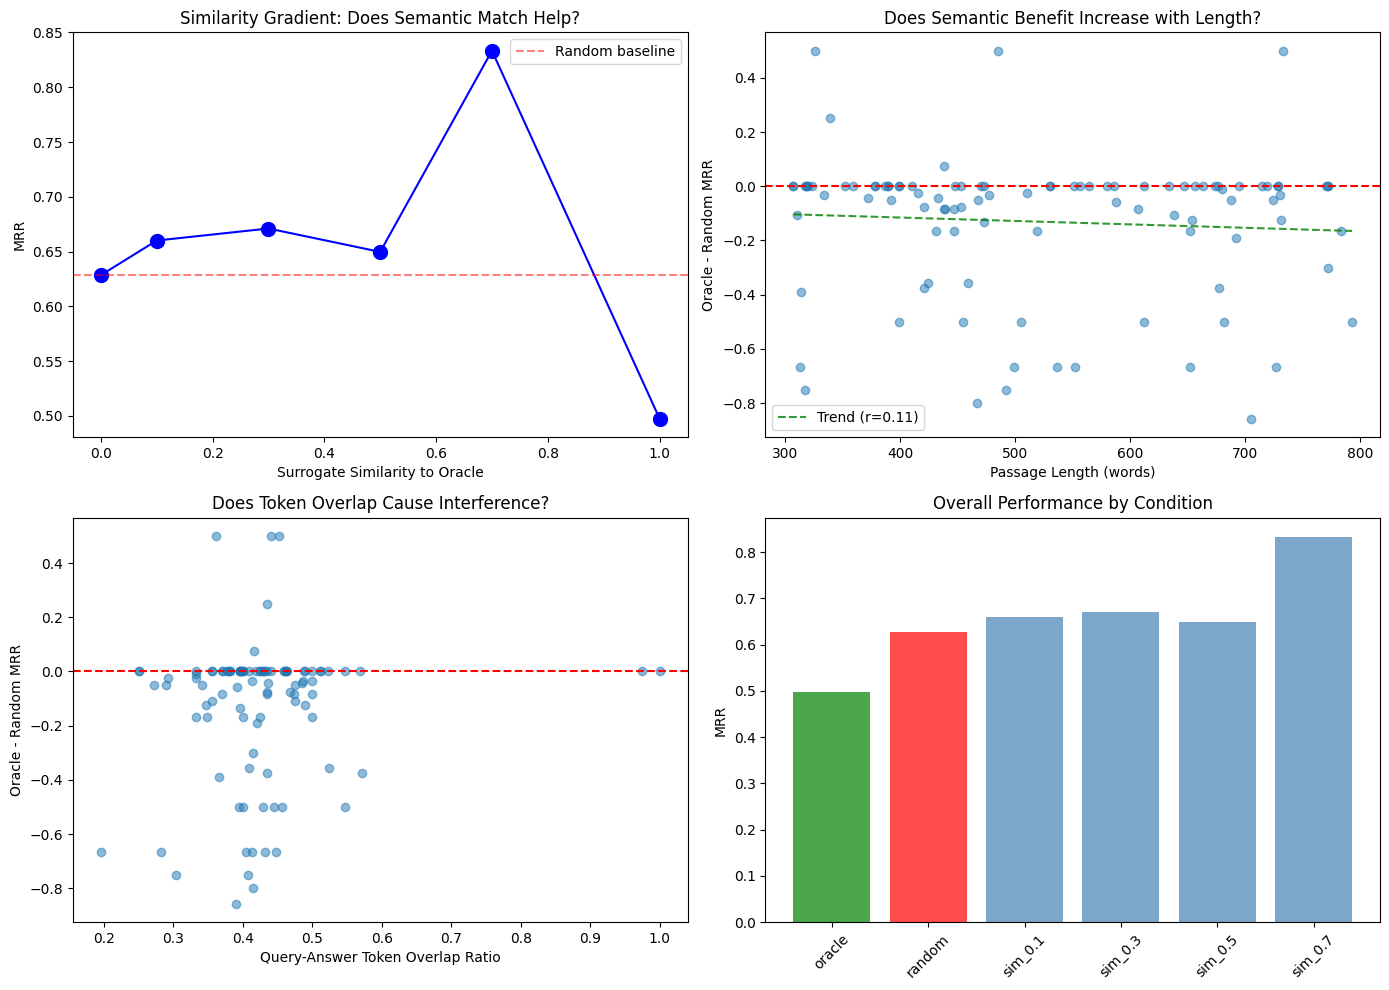

Saved to /home/jupyter/research/directed_kvcache/results/exp17/17_analysis.png


In [12]:
# Cell 12: Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Similarity gradient
ax1 = axes[0, 0]
if gradient_data:
    sims = [x[0] for x in gradient_data]
    mrrs = [x[1] for x in gradient_data]
    ax1.plot(sims, mrrs, 'bo-', markersize=10)
    ax1.set_xlabel('Surrogate Similarity to Oracle')
    ax1.set_ylabel('MRR')
    ax1.set_title('Similarity Gradient: Does Semantic Match Help?')
    ax1.axhline(y=mrrs[0], color='r', linestyle='--', alpha=0.5, label='Random baseline')
    ax1.legend()

# Plot 2: Oracle vs Random by passage length
ax2 = axes[0, 1]
if 'oracle' in results and 'random' in results and length_analysis:
    lengths = [x[0] for x in length_analysis]
    deltas = [x[1] for x in length_analysis]
    ax2.scatter(lengths, deltas, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Passage Length (words)')
    ax2.set_ylabel('Oracle - Random MRR')
    ax2.set_title('Does Semantic Benefit Increase with Length?')
    # Add trend line
    z = np.polyfit(lengths, deltas, 1)
    p = np.poly1d(z)
    ax2.plot(sorted(lengths), p(sorted(lengths)), 'g--', alpha=0.8, label=f'Trend (r={corr:.2f})')
    ax2.legend()

# Plot 3: Token overlap vs oracle benefit
ax3 = axes[1, 0]
if overlap_analysis:
    overlaps = [x[0] for x in overlap_analysis]
    deltas = [x[1] for x in overlap_analysis]
    ax3.scatter(overlaps, deltas, alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel('Query-Answer Token Overlap Ratio')
    ax3.set_ylabel('Oracle - Random MRR')
    ax3.set_title('Does Token Overlap Cause Interference?')

# Plot 4: Overall comparison
ax4 = axes[1, 1]
conditions = list(summary.keys())
mrrs = [summary[c]['mrr'] for c in conditions]
colors = ['green' if c == 'oracle' else 'red' if c == 'random' else 'steelblue' for c in conditions]
ax4.bar(range(len(conditions)), mrrs, color=colors, alpha=0.7)
ax4.set_xticks(range(len(conditions)))
ax4.set_xticklabels(conditions, rotation=45)
ax4.set_ylabel('MRR')
ax4.set_title('Overall Performance by Condition')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '17_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to {RESULTS_DIR / '17_analysis.png'}")

In [13]:
# Cell 13: Save Final Results

final_results = {
    'metadata': {
        'experiment': '17_semantic_signal_investigation',
        'timestamp': time.strftime('%Y-%m-%dT%H:%M:%S'),
        'n_pages': len(ranking_task),
        'mean_word_count': np.mean([p['word_count'] for p in ranking_task]),
        'seed': SEED
    },
    'summary': summary,
    'conclusions': {
        'oracle_vs_random': None,
        'similarity_gradient_correlation': None,
        'length_effect': None,
        'overlap_effect': None
    }
}

# Fill in conclusions
if 'oracle' in summary and 'random' in summary:
    delta = summary['oracle']['mrr'] - summary['random']['mrr']
    final_results['conclusions']['oracle_vs_random'] = {
        'delta': delta,
        'winner': 'oracle' if delta > 0 else 'random'
    }

with open(RESULTS_DIR / '17_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n" + "="*70)
print("FINAL CONCLUSIONS")
print("="*70)
print(f"\nResults saved to {RESULTS_DIR / '17_results.json'}")

if final_results['conclusions']['oracle_vs_random']:
    winner = final_results['conclusions']['oracle_vs_random']['winner']
    delta = final_results['conclusions']['oracle_vs_random']['delta']
    print(f"\nOracle vs Random: {winner.upper()} wins by {abs(delta):.4f} MRR")


FINAL CONCLUSIONS

Results saved to /home/jupyter/research/directed_kvcache/results/exp17/17_results.json

Oracle vs Random: RANDOM wins by 0.1309 MRR
